In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.append("/n/home12/binxuwang/Github/Closed-loop-visual-insilico")
import timm
import torch
import torch as th
import torch.nn as nn
from torchvision.models.feature_extraction import create_feature_extractor
from tqdm.auto import tqdm
from os.path import join
import pickle as pkl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from horama import maco, plot_maco
import torchvision.transforms as T
from torchvision.transforms import ToPILImage, ToTensor, Normalize, Resize
from torchvision.models import resnet50
from circuit_toolkit.CNN_scorers import TorchScorer
from circuit_toolkit.GAN_utils import upconvGAN, Caffenet
from circuit_toolkit.plot_utils import to_imgrid, show_imgrid, save_imgrid, saveallforms
from circuit_toolkit.layer_hook_utils import featureFetcher_module, featureFetcher, get_module_names
from circuit_toolkit.dataset_utils import ImagePathDataset
from torch.utils.data import DataLoader
from neural_regress.regress_lib import sweep_regressors
from neural_regress.sklearn_torchify_lib import SRP_torch, PCA_torch, LinearRegression_torch, SpatialAvg_torch

import sklearn
from sklearn.pipeline import make_pipeline
from sklearn.random_projection import SparseRandomProjection, GaussianRandomProjection
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import RidgeCV
from sklearn.decomposition import PCA
from sklearn.kernel_ridge import KernelRidge

#%% Utility Functions
from core.data_utils import load_from_hdf5, load_neural_data, load_neural_trial_resp_tensor, create_response_tensor

In [3]:
from core.data_utils import load_neural_data, load_from_hdf5, load_neural_trial_resp_tensor, create_response_tensor
dataroot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation"
data_path = join(dataroot, "vvs-accentuate-day1_normalize_paul_241119-241122.h5")
data = load_from_hdf5(data_path)

In [4]:
print("subjects:", list(data.keys()))

subjects: ['paul_20241119-20241122', 'paul_241119-241122']


In [5]:
subject_id = 'paul_20241119-20241122'
stim_names, rspavg_resp_peak, resp_tensor, trial_counters = load_neural_trial_resp_tensor(data_path, subject_id)

Trials shape: (7174,) (7174, 64)
Rspavg shape: (1028,) (1028, 64)
Response tensor shape (stimulus x neuron x trial): (1028, 64, 8)
Response tensor shape: (1028, 64, 8)
Trial counters shape: (1028,)
min and max trial counters: 5 8


In [6]:
subject_id = 'paul_241119-241122'
stim_names, rspavg_resp_peak, resp_tensor, trial_counters = load_neural_trial_resp_tensor(data_path, subject_id)

Trials shape: (7174,) (7174, 383)
Rspavg shape: (1028,) (1028, 383)
Response tensor shape (stimulus x neuron x trial): (1028, 383, 8)
Response tensor shape: (1028, 383, 8)
Trial counters shape: (1028,)
min and max trial counters: 5 8


In [7]:
stim_names

array([b'clip_neg_0_2048_tr.png', b'clip_neg_0_512_tr.png',
       b'clip_neg_1_2048_tr.png', ..., b'shared0990_nsd71929.png',
       b'shared0994_nsd72210.png', b'shared0995_nsd72258.png'],
      dtype=object)

In [11]:
(trial_counters == 8).sum()

233

In [14]:
len(stim_names)

1028

In [12]:
subject_id = 'paul_20241119-20241122'
ncsnr = data[subject_id]["neuron_metadata"]["ncsnr"]
reliability = data[subject_id]["neuron_metadata"]["reliability"]
brain_area = data[subject_id]["neuron_metadata"]["brain_area"]
stim_names, rspavg_resp_peak, resp_tensor, trial_counters = load_neural_trial_resp_tensor(data_path, subject_id)

Trials shape: (7174,) (7174, 64)
Rspavg shape: (1028,) (1028, 64)
Response tensor shape (stimulus x neuron x trial): (1028, 64, 8)
Response tensor shape: (1028, 64, 8)
Trial counters shape: (1028,)
min and max trial counters: 5 8


In [15]:
model_names = ["r50", "robustr50", "dinov1", "clip"]
directions = ["pos", "neg"]
direction = directions[0]
syn_stim_idxs = []
nat_stim_idxs = []
stim_names_str = [stimname.decode('utf8') for stimname in stim_names]
for unit_id in range(0, 8):
    for resol in [512, 2048]:
        for direction in directions:
            for model_name in model_names:
                stimname = f"{model_name}_{direction}_{unit_id}_{resol}_tr.png"
                # find the index of the stimulus name in trials_stim_names
                idx = stim_names_str.index(stimname)
                syn_stim_idxs.append(idx)

nat_stim_idxs = np.arange(len(stim_names))
# get rid of the syn_stim_idxs
nat_stim_idxs = np.setdiff1d(nat_stim_idxs, syn_stim_idxs)
# find the index of the stimulus name in stim_names
syn_stim_idxs = np.array(syn_stim_idxs).reshape(8, 2, len(directions), len(model_names))
print(syn_stim_idxs.shape)
print(nat_stim_idxs.shape)
# use syn_stim_idxs to index into resp_matrix 

(8, 2, 2, 4)
(900,)


Select channels with ncsnr > 0.75 13 / 64
(8, 2, 2, 4, 13)
(900, 13)


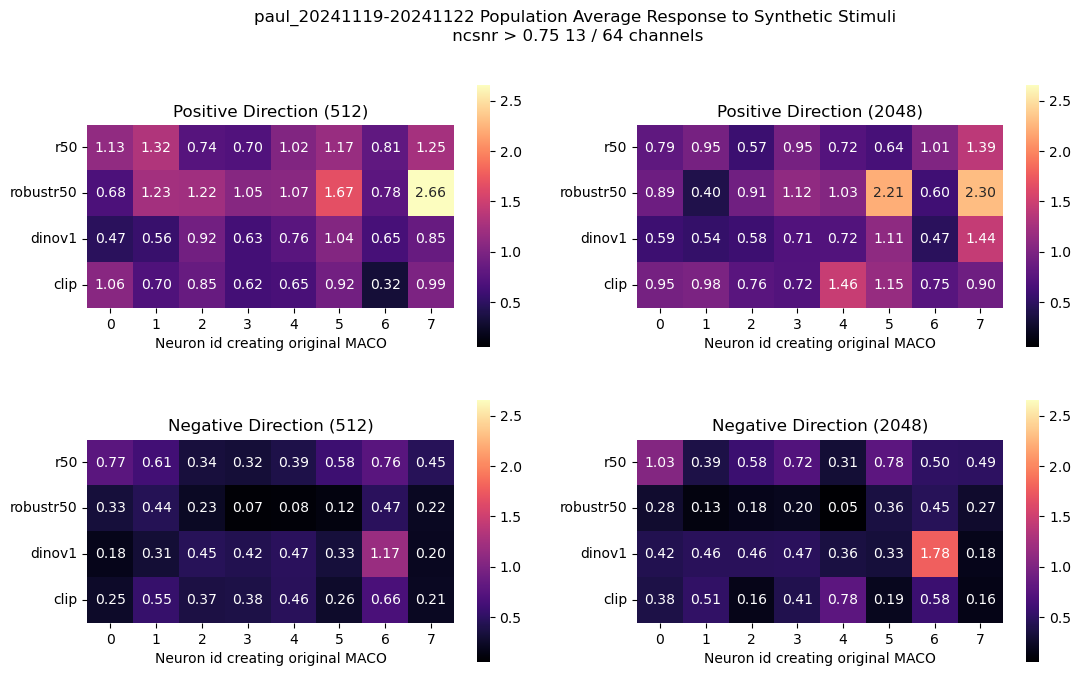

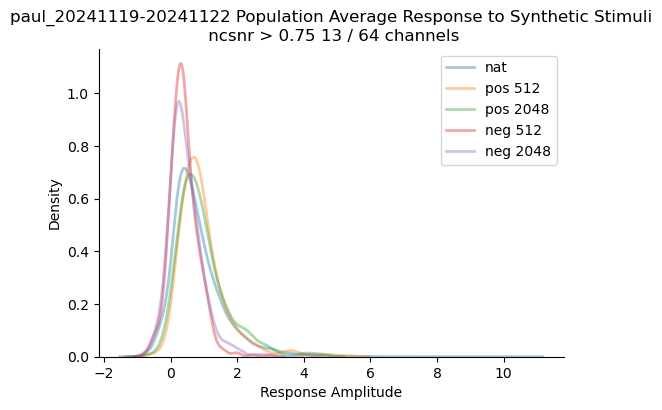

In [16]:
thresh = 0.75
cmap = "magma"
chan_mask = ncsnr > thresh
print(f"Select channels with ncsnr > {thresh} {chan_mask.sum()} / {ncsnr.shape[0]}")
rspavg_resp_peak_selected = rspavg_resp_peak[:, chan_mask]
syn_stim_resp_tsr = rspavg_resp_peak_selected[syn_stim_idxs, :]
nat_stim_resp_tsr = rspavg_resp_peak_selected[nat_stim_idxs, :]
print(syn_stim_resp_tsr.shape)
print(nat_stim_resp_tsr.shape)
syn_stim_resp_popavg = syn_stim_resp_tsr.mean(axis=-1)
nat_stim_resp_popavg = nat_stim_resp_tsr.mean(axis=-1)

# Find global min and max for consistent color scaling
vmin = syn_stim_resp_popavg.min()
vmax = syn_stim_resp_popavg.max()

figh, axh = plt.subplots(2, 2, figsize=(13, 7.5))
plt.sca(axh[0,0])
im0 = sns.heatmap(syn_stim_resp_popavg[:,0,0,:].T, vmin=vmin, vmax=vmax, cmap=cmap, cbar=True, annot=True, fmt=".2f", yticklabels=model_names)
plt.axis("image")
# rotate yticklabels
plt.yticks(rotation=0)
plt.xlabel("Neuron id creating original MACO")
# plt.colorbar(im0)
plt.title("Positive Direction (512)")

plt.sca(axh[0,1])
im0 = sns.heatmap(syn_stim_resp_popavg[:,1,0,:].T, vmin=vmin, vmax=vmax, cmap=cmap, cbar=True, annot=True, fmt=".2f", yticklabels=model_names, )
plt.axis("image")
plt.yticks(rotation=0)
plt.xlabel("Neuron id creating original MACO")
# plt.colorbar(im0)
plt.title("Positive Direction (2048)")

plt.sca(axh[1,0])
im1 = sns.heatmap(syn_stim_resp_popavg[:,0,1,:].T, vmin=vmin, vmax=vmax, cmap=cmap, cbar=True, annot=True, fmt=".2f", yticklabels=model_names)
plt.axis("image")
plt.yticks(rotation=0)
# plt.colorbar(im1)
plt.xlabel("Neuron id creating original MACO")
plt.title("Negative Direction (512)")

plt.sca(axh[1,1])
im1 = sns.heatmap(syn_stim_resp_popavg[:,1,1,:].T, vmin=vmin, vmax=vmax, cmap=cmap, cbar=True, annot=True, fmt=".2f", yticklabels=model_names)
plt.axis("image")
plt.yticks(rotation=0)
# plt.colorbar(im1)
plt.xlabel("Neuron id creating original MACO")
plt.title("Negative Direction (2048)")

plt.suptitle(f"{subject_id} Population Average Response to Synthetic Stimuli\n ncsnr > {thresh} {chan_mask.sum()} / {ncsnr.shape[0]} channels")
plt.show()

plt.figure(figsize=(6, 4))
# plot kde with dots showing data points
sns.kdeplot(data=nat_stim_resp_tsr.flatten(), label="nat", alpha=0.4, lw=2)
# sns.rugplot(data=nat_stim_resp_tsr.flatten(), height=0.05, alpha=0.2)
sns.kdeplot(data=syn_stim_resp_tsr[:,0,0,:].flatten(), label="pos 512", alpha=0.4, lw=2)
# sns.rugplot(data=syn_stim_resp_tsr[:,0,0,:].flatten(), height=0.05, alpha=0.2)
sns.kdeplot(data=syn_stim_resp_tsr[:,1,0,:].flatten(), label="pos 2048", alpha=0.4, lw=2)
# sns.rugplot(data=syn_stim_resp_tsr[:,1,0,:].flatten(), height=0.05, alpha=0.2)
sns.kdeplot(data=syn_stim_resp_tsr[:,0,1,:].flatten(), label="neg 512", alpha=0.4, lw=2)
# sns.rugplot(data=syn_stim_resp_tsr[:,0,1,:].flatten(), height=0.05, alpha=0.2)
sns.kdeplot(data=syn_stim_resp_tsr[:,1,1,:].flatten(), label="neg 2048", alpha=0.4, lw=2)
# sns.rugplot(data=syn_stim_resp_tsr[:,1,1,:].flatten(), height=0.05, alpha=0.2)
plt.legend()
plt.title(f"{subject_id} Population Average Response to Synthetic Stimuli\n ncsnr > {thresh} {chan_mask.sum()} / {ncsnr.shape[0]} channels")
plt.xlabel("Response Amplitude")
plt.ylabel("Density")
plt.show()

Trials shape: (7174,) (7174, 383)
Rspavg shape: (1028,) (1028, 383)
Response tensor shape (stimulus x neuron x trial): (1028, 383, 8)
Response tensor shape: (1028, 383, 8)
Trial counters shape: (1028,)
min and max trial counters: 5 8
(8, 2, 2, 4)
(900,)
Select channels with ncsnr > 0.45 5 / 383
(8, 2, 2, 4, 5)
(900, 5)


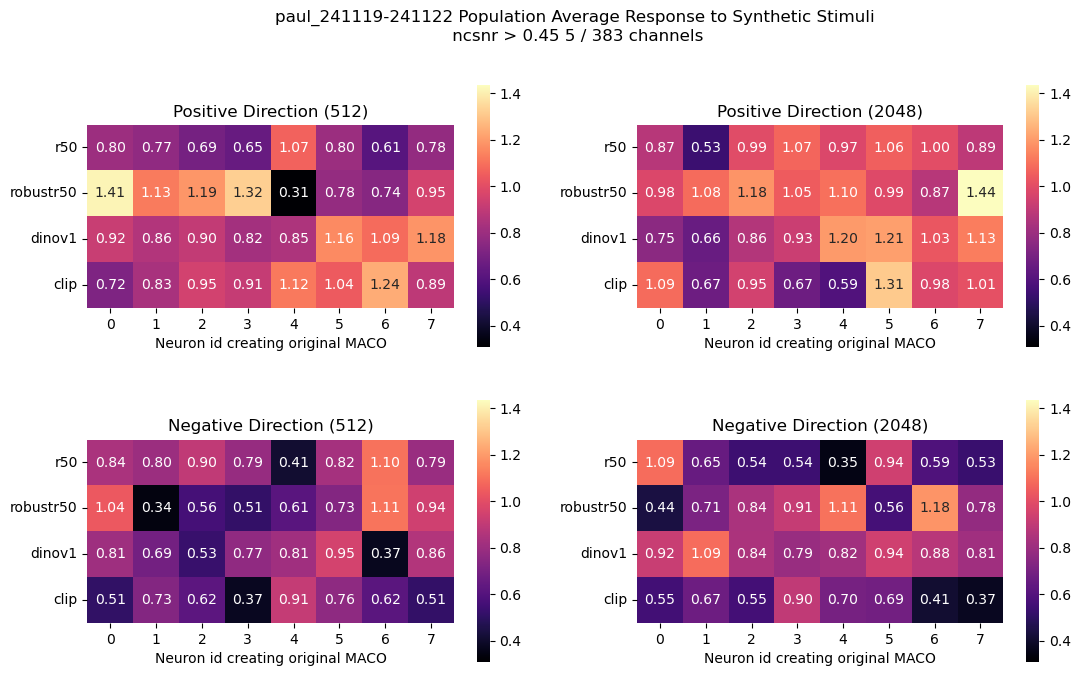

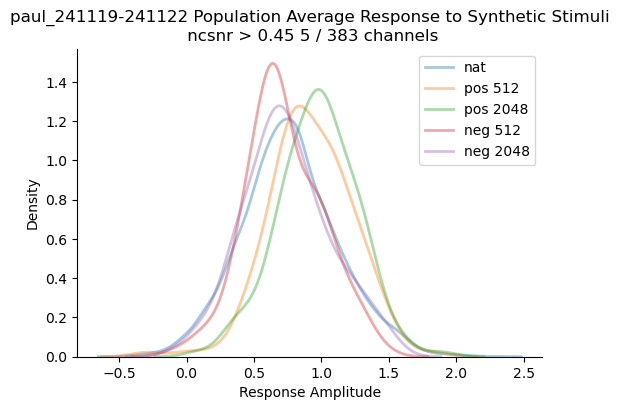

In [17]:
subject_id = 'paul_241119-241122'
ncsnr = data[subject_id]["neuron_metadata"]["ncsnr"]
reliability = data[subject_id]["neuron_metadata"]["reliability"]
brain_area = data[subject_id]["neuron_metadata"]["brain_area"]
stim_names, rspavg_resp_peak, resp_tensor, trial_counters = load_neural_trial_resp_tensor(data_path, subject_id)
model_names = ["r50", "robustr50", "dinov1", "clip"]
directions = ["pos", "neg"]
direction = directions[0]
syn_stim_idxs = []
nat_stim_idxs = []
stim_names_str = [stimname.decode('utf8') for stimname in stim_names]
for unit_id in range(0, 8):
    for resol in [512, 2048]:
        for direction in directions:
            for model_name in model_names:
                stimname = f"{model_name}_{direction}_{unit_id}_{resol}_tr.png"
                # find the index of the stimulus name in trials_stim_names
                idx = stim_names_str.index(stimname)
                syn_stim_idxs.append(idx)

nat_stim_idxs = np.arange(len(stim_names))
# get rid of the syn_stim_idxs
nat_stim_idxs = np.setdiff1d(nat_stim_idxs, syn_stim_idxs)
# find the index of the stimulus name in stim_names
syn_stim_idxs = np.array(syn_stim_idxs).reshape(8, 2, len(directions), len(model_names))
print(syn_stim_idxs.shape)
print(nat_stim_idxs.shape)
# use syn_stim_idxs to index into resp_matrix 
thresh = 0.45
cmap = "magma"
chan_mask = ncsnr > thresh
print(f"Select channels with ncsnr > {thresh} {chan_mask.sum()} / {ncsnr.shape[0]}")
rspavg_resp_peak_selected = rspavg_resp_peak[:, chan_mask]
syn_stim_resp_tsr = rspavg_resp_peak_selected[syn_stim_idxs, :]
nat_stim_resp_tsr = rspavg_resp_peak_selected[nat_stim_idxs, :]
print(syn_stim_resp_tsr.shape)
print(nat_stim_resp_tsr.shape)
syn_stim_resp_popavg = syn_stim_resp_tsr.mean(axis=-1)
nat_stim_resp_popavg = nat_stim_resp_tsr.mean(axis=-1)

# Find global min and max for consistent color scaling
vmin = syn_stim_resp_popavg.min()
vmax = syn_stim_resp_popavg.max()

figh, axh = plt.subplots(2, 2, figsize=(13, 7.5))
plt.sca(axh[0,0])
im0 = sns.heatmap(syn_stim_resp_popavg[:,0,0,:].T, vmin=vmin, vmax=vmax, cmap=cmap, cbar=True, annot=True, fmt=".2f", yticklabels=model_names)
plt.axis("image")
# rotate yticklabels
plt.yticks(rotation=0)
plt.xlabel("Neuron id creating original MACO")
# plt.colorbar(im0)
plt.title("Positive Direction (512)")

plt.sca(axh[0,1])
im0 = sns.heatmap(syn_stim_resp_popavg[:,1,0,:].T, vmin=vmin, vmax=vmax, cmap=cmap, cbar=True, annot=True, fmt=".2f", yticklabels=model_names, )
plt.axis("image")
plt.yticks(rotation=0)
plt.xlabel("Neuron id creating original MACO")
# plt.colorbar(im0)
plt.title("Positive Direction (2048)")

plt.sca(axh[1,0])
im1 = sns.heatmap(syn_stim_resp_popavg[:,0,1,:].T, vmin=vmin, vmax=vmax, cmap=cmap, cbar=True, annot=True, fmt=".2f", yticklabels=model_names)
plt.axis("image")
plt.yticks(rotation=0)
# plt.colorbar(im1)
plt.xlabel("Neuron id creating original MACO")
plt.title("Negative Direction (512)")

plt.sca(axh[1,1])
im1 = sns.heatmap(syn_stim_resp_popavg[:,1,1,:].T, vmin=vmin, vmax=vmax, cmap=cmap, cbar=True, annot=True, fmt=".2f", yticklabels=model_names)
plt.axis("image")
plt.yticks(rotation=0)
# plt.colorbar(im1)
plt.xlabel("Neuron id creating original MACO")
plt.title("Negative Direction (2048)")

plt.suptitle(f"{subject_id} Population Average Response to Synthetic Stimuli\n ncsnr > {thresh} {chan_mask.sum()} / {ncsnr.shape[0]} channels")
plt.show()

plt.figure(figsize=(6, 4))
# plot kde with dots showing data points
sns.kdeplot(data=nat_stim_resp_tsr.flatten(), label="nat", alpha=0.4, lw=2)
# sns.rugplot(data=nat_stim_resp_tsr.flatten(), height=0.05, alpha=0.2)
sns.kdeplot(data=syn_stim_resp_tsr[:,0,0,:].flatten(), label="pos 512", alpha=0.4, lw=2)
# sns.rugplot(data=syn_stim_resp_tsr[:,0,0,:].flatten(), height=0.05, alpha=0.2)
sns.kdeplot(data=syn_stim_resp_tsr[:,1,0,:].flatten(), label="pos 2048", alpha=0.4, lw=2)
# sns.rugplot(data=syn_stim_resp_tsr[:,1,0,:].flatten(), height=0.05, alpha=0.2)
sns.kdeplot(data=syn_stim_resp_tsr[:,0,1,:].flatten(), label="neg 512", alpha=0.4, lw=2)
# sns.rugplot(data=syn_stim_resp_tsr[:,0,1,:].flatten(), height=0.05, alpha=0.2)
sns.kdeplot(data=syn_stim_resp_tsr[:,1,1,:].flatten(), label="neg 2048", alpha=0.4, lw=2)
# sns.rugplot(data=syn_stim_resp_tsr[:,1,1,:].flatten(), height=0.05, alpha=0.2)
plt.legend()
plt.title(f"{subject_id} Population Average Response to Synthetic Stimuli\n ncsnr > {thresh} {chan_mask.sum()} / {ncsnr.shape[0]} channels")
plt.xlabel("Response Amplitude")
plt.ylabel("Density")
plt.show()

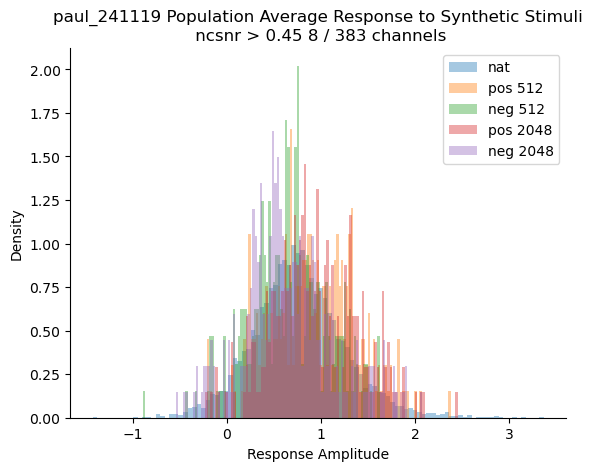

In [36]:
# plot histogram of nat_stim_resp_tsr
plt.hist(nat_stim_resp_tsr.flatten(), bins=100, density=True, label="nat", alpha=0.4)
plt.hist(syn_stim_resp_tsr[:,0,0,:].flatten(), bins=100, density=True, label="pos 512", alpha=0.4)
plt.hist(syn_stim_resp_tsr[:,0,1,:].flatten(), bins=100, density=True, label="neg 512", alpha=0.4)
plt.hist(syn_stim_resp_tsr[:,1,0,:].flatten(), bins=100, density=True, label="pos 2048", alpha=0.4)
plt.hist(syn_stim_resp_tsr[:,1,1,:].flatten(), bins=100, density=True, label="neg 2048", alpha=0.4)
plt.legend()
plt.title(f"{subject_id} Population Average Response to Synthetic Stimuli\n ncsnr > {thresh} {chan_mask.sum()} / {ncsnr.shape[0]} channels")
plt.xlabel("Response Amplitude")
plt.ylabel("Density")
plt.show()


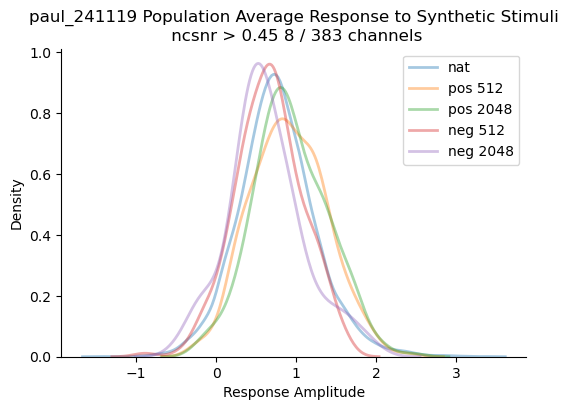

In [45]:
plt.figure(figsize=(6, 4))
# plot kde with dots showing data points
sns.kdeplot(data=nat_stim_resp_tsr.flatten(), label="nat", alpha=0.4, lw=2)
# sns.rugplot(data=nat_stim_resp_tsr.flatten(), height=0.05, alpha=0.2)
sns.kdeplot(data=syn_stim_resp_tsr[:,0,0,:].flatten(), label="pos 512", alpha=0.4, lw=2)
# sns.rugplot(data=syn_stim_resp_tsr[:,0,0,:].flatten(), height=0.05, alpha=0.2)
sns.kdeplot(data=syn_stim_resp_tsr[:,1,0,:].flatten(), label="pos 2048", alpha=0.4, lw=2)
# sns.rugplot(data=syn_stim_resp_tsr[:,1,0,:].flatten(), height=0.05, alpha=0.2)
sns.kdeplot(data=syn_stim_resp_tsr[:,0,1,:].flatten(), label="neg 512", alpha=0.4, lw=2)
# sns.rugplot(data=syn_stim_resp_tsr[:,0,1,:].flatten(), height=0.05, alpha=0.2)
sns.kdeplot(data=syn_stim_resp_tsr[:,1,1,:].flatten(), label="neg 2048", alpha=0.4, lw=2)
# sns.rugplot(data=syn_stim_resp_tsr[:,1,1,:].flatten(), height=0.05, alpha=0.2)
plt.legend()
plt.title(f"{subject_id} Population Average Response to Synthetic Stimuli\n ncsnr > {thresh} {chan_mask.sum()} / {ncsnr.shape[0]} channels")
plt.xlabel("Response Amplitude")
plt.ylabel("Density")
plt.show()

In [6]:
subject_id = 'paul_240713-240710'
trials_resp_peak = data[subject_id]['trials']['response_peak']
trials_stim_names = data[subject_id]['trials']['stimulus_name']
rspavg_resp_peak = data[subject_id]['repavg']['response_peak']
rspavg_stim_names = data[subject_id]['repavg']['stimulus_name']

print(trials_resp_peak.shape, trials_stim_names.shape) # (29769, 383) (29769,)
print(rspavg_resp_peak.shape, rspavg_stim_names.shape) # (383, 1000) (383,)

# create a tensor, stimulus by neuron by trial
# using trials_stim_names find the index of the stimulus in rspavg_stim_names
# then use that index to index into rspavg_resp_peak
# then stack trials_resp_peak and the rspavg_resp_peak along the trial dimension

(29769, 383) (29769,)
(1110, 383) (1110,)


In [6]:
from core.data_utils import load_from_hdf5
dataroot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation"
subject_id = 'paul_240713-240710'
resp_tensor, trial_counters = load_neural_trial_resp_tensor(data_path, subject_id)

Trials shape: (29769,) (29769, 383)
Rspavg shape: (1110,)
Response tensor shape (stimulus x neuron x trial): (1110, 383, 29)
Response tensor shape: (1110, 383, 29)
Trial counters shape: (1110,)
min and max trial counters: 26 29


In [7]:
# Create a dictionary mapping stimulus names to indices
stim_to_idx = {name.decode('utf8'): i for i, name in enumerate(rspavg_stim_names)}

# Initialize list to store trial counts for each stimulus
trial_counts = np.zeros(len(rspavg_stim_names), dtype=int)
# Count trials per stimulus
for stim_name in trials_stim_names:
    trial_counts[stim_to_idx[stim_name.decode('utf8')]] += 1
max_trials = trial_counts.max()
# Initialize 3D tensor (stimulus x neuron x trial)
resp_tensor = np.full((len(rspavg_stim_names), trials_resp_peak.shape[1], max_trials), np.nan)
trial_counters = np.zeros(len(rspavg_stim_names), dtype=int)
# Fill in the tensor with trial responses
for trial_idx, (stim_name, trial_resp) in enumerate(zip(trials_stim_names, trials_resp_peak)):
    stim_idx = stim_to_idx[stim_name.decode('utf8')]
    resp_tensor[stim_idx, :, trial_counters[stim_idx]] = trial_resp
    trial_counters[stim_idx] += 1

print(f"Response tensor shape (stimulus x neuron x trial): {resp_tensor.shape}")

Response tensor shape (stimulus x neuron x trial): (1110, 383, 29)


In [8]:
resp_tensor.shape

(1110, 383, 29)

In [10]:
trial_counters.min(), trial_counters.max()

(26, 29)

In [12]:
# chekc no nan 
print(np.isnan(resp_tensor).sum())
print(np.isnan(resp_tensor[:, :, :26]).sum())


927243
0


In [13]:
resp_tensor.dtype

dtype('float64')

In [14]:
dataroot

'/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation'

In [15]:
np.save(join(dataroot, f"{subject_id}_trial_resp_tensor.npy"), resp_tensor)

In [17]:
!du -sh {dataroot}/*

8.0K	/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation/model_outputs
6.4G	/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation/nsd_shared1000_6monkeys_2024.h5
65G	/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation/paul_240713-240710
95M	/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation/paul_240713-240710_trial_resp_tensor.npy
339M	/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation/shared1000
336M	/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation/shared1000_images.tar.gz
3.1G	/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation/stimuli_pilot_20241119


In [18]:
from sklearn.model_selection import train_test_split, GridSearchCV
idx_train, idx_test = train_test_split(
        np.arange(1110), test_size=0.2, random_state=42, shuffle=True
    )
np.savez(join(dataroot, f"{subject_id}_trial_resp_tensor_train_test_idx.npz"), idx_train=idx_train, idx_test=idx_test)